
# Genie.jl Evolution Simulation Package

**Genie.jl** is a Julia package designed to simulate the evolution of multiple sequence alignments (MSAs) based on specified parameters and conditions. Its primary function, `run_evolution`, enables users to simulate evolutionary trajectories for amino acid or nucleotide codon sequences under complex interaction parameters.


 Importing the package itself and some auxiliary packages to read files and plot

In [1]:
using Genie, DCAUtils, JLD2, PyPlot

Reading the model parameters

- **`h_dbd::Array{T,2}`**: A 2D array of size `(q, L)` representing the field parameters.

- **`J_dbd::Array{T,4}`**: A 4D array of size `(q, L, q, L)` representing the coupling parameters.

In [2]:
@load "example_model.jld2"

2-element Vector{Symbol}:
 :h_dbd
 :J_dbd

Reading the natural alignment on which the model was trained

- **`nat_msa::Array{Int8,2}`**: Natural MSA as a 2D array. The array dimensions must be `(L, M)`, where `L` is the sequence length, and each column represents a different sequence.

In [5]:
nat_msa  = read_fasta_alignment("example_alignment.a2m", 0.9);
q = 21; L = size(nat_msa,1);

## Key Function: `run_evolution`

### Overview
The `run_evolution` function simulates the evolution of a given multiple sequence alignment (MSA) over a specified number of steps. It uses a combination of Gibbs sampling and Metropolis sampling to evolve the sequences, supporting options for random initialization, codon usage bias, and saving intermediate MSAs at specified intervals.

### Parameters

- **`h_dbd::Array{T,2}`**: A 2D array of size `(q, L)` representing the field parameters.

- **`J_dbd::Array{T,4}`**: A 4D array of size `(q, L, q, L)` representing the coupling parameters.

- **`start_msa::Array{T,2}`**: Initial MSA as a 2D array where `T` can be either `Int8` for amino acids or `String` for nucleotide codons. If amino acids are provided, the corresponding codons will be randomly sampled among those coding for the amino acids. The array dimensions must be `(L, M)`, where `L` is the sequence length, and each column represents a different sequence.


### Optional Parameters
- **`N_steps::Int`**: Number of steps for the simulation (default is 100).
- **`temp`**: Temperature parameter for the simulation (default is 1.0).
- **`p`**: Probability for choosing Metropolis Sampling (default is 0.5). A value of `0` will use only Gibbs Sampling with single nucleotide mutations, while `1` will use only Metropolis Sampling with indels.
- **`N_points::Union{Int, Nothing}`**: Number of points to save the MSA in logarithmic scale along the trajectory (default is `nothing`). Specify either `N_points` or `each_step`, but not both.
- **`each_step::Union{Int, Nothing}`**: Interval to save the MSA every `each_step` steps along the trajectory (default is `nothing`). Specify either `N_points` or `each_step`, but not both.
- **`rand_init::Bool`**: Whether to initialize sequences randomly (default is `false`).
- **`q::Int`**: Number of unique amino acids in the sequences (default is 21).
- **`codon_bias::Union{Nothing, Dict{String, Float64}}`**: Codon usage bias dictionary (default is `nothing`; assumes no codon bias).
- **`verbose::Bool`**: Whether to print progress information (default is `false`).

### Returns
The function returns a named tuple containing the results of the simulation. The structure of the output depends on whether `N_points` or `each_step` is specified.

1. **If `N_points` or `each_step` are not specified**:
   - **`msa::Array{Int8, 2}`**: Final MSA in amino acid form.
   - **`msa_dna::Array{String, 2}`**: Final MSA in DNA format.
   - **`codon_usage::Dict{String, Float64}`**: Codon usage dictionary used in the simulation.
   - **`p::Float64`**: Probability of choosing Metropolis Sampling.
   - **`temp::Float64`**: Temperature used in the simulation.

2. **If either `N_points` or `each_step` are specified**:
   - **`step_msa::Array{Array{Int8, 2}, 1}`**: List of MSAs at different time points in amino acid format.
   - **`msa_dna::Array{Array{String, 2}, 1}`**: List of MSAs in DNA format at different time points.
   - **`codon_usage::Dict{String, Float64}`**: Codon usage dictionary used in the simulation.
   - **`p::Float64`**: Probability of choosing Metropolis Sampling.
   - **`temp::Float64`**: Temperature used in the simulation.
   - **`steps::Array{Int, 1}`**: Steps at which MSAs were saved.

### Description
The `run_evolution` function simulates the evolution of an initial MSA over a specified number of steps. It employs both Gibbs sampling and Metropolis sampling to generate evolved sequences, with options for random initialization, codon usage bias, and saving intermediate MSAs at specified intervals. The function is highly customizable and suitable for simulating complex evolutionary dynamics under various conditions.



In [6]:
start_msa = hcat([nat_msa[:,1] for i in 1:1000]...);

@time res = run_evolution(start_msa, 
    h_dbd, 
    J_dbd,
    p = 0.5, 
    temp = 1., 
    N_steps = 1*10^5,  
    N_points = 20, 
    verbose = true);

1
3
6
11
20
37
69
127
233
428
784
1438
2636
4832
8858
16237
29763
54555
100000
 86.533652 seconds (13.51 M allocations: 1007.078 MiB, 0.29% gc time, 2.94% compilation time)


## Function: `check_equilibration`

### Purpose
The `check_equilibration` function evaluates the equilibration of a Markov Chain Monte Carlo (MCMC) process by comparing simulated and natural sequence data. It computes various metrics and generates plots to assess the convergence of simulated sequences to a target distribution.

### Parameters
- `folder::String`: Path to the directory where output images will be saved.
- `nat_msa::Array{Int8,2}`: Natural multiple sequence alignment (MSA) matrix, with each sequence encoded as `Int8`. The array should be in the format `(L, M)`, where `L` is the sequence length, and `M` is the number of sequences.
- `step_msa::Array{Array{Int8,2},1}`: Array containing MSA matrices at each step of the MCMC simulation.
- `steps::Array{Int,1}`: Array representing the MCMC steps associated with each element in `step_msa`.

### Process
1. **Validation**:
   - Checks that `nat_msa` and `step_msa` have matching sequence lengths.
   - Confirms that the number of MCMC steps aligns with the length of `step_msa`.

2. **Computing Frequencies and Correlations**:
   - Uses `compute_weighted_frequencies` to obtain weighted single- and pair-wise frequencies for the natural and simulated MSAs.
   - Computes Pearson correlations between the natural and simulated sequence frequencies at each step.

3. **Distance Calculation**:
   - Calculates the mean and variance of Hamming distances between the initial and subsequent steps of the MCMC simulation.
   - Compares these metrics with the natural sequence data to assess convergence.

4. **PCA Projection**:
   - Performs Principal Component Analysis (PCA) on `nat_msa` and projects the final simulated MSA onto the same principal components to visualize the sequence space.

5. **Plotting Results**:
   - **Frequency Correlation Plot**: Tracks Pearson correlations over MCMC steps for 1-point, 2-point, and connected correlations.
   - **Frequency Comparison Plot**: Compares natural and final simulated 1-point frequencies.
   - **Mean and Variance of Hamming Distance**: Plots mean and variance of Hamming distances over MCMC steps, both for simulated and natural sequences.
   - **PCA Density Plots**: Visualizes natural and simulated sequences in PCA space.

### Outputs
The function saves the following plots to the specified `folder`:
- `"freq_corr_evol.png"`: Correlations between simulated and natural frequencies over MCMC steps.
- `"final_freq_natvssim.png"`: Comparison of 1-point frequencies between natural and final simulated sequences.
- `"mean_hamming.png"`: Mean Hamming distance from wild type across steps.
- `"var_hamming.png"`: Variance of Hamming distance from wild type across steps.
- `"pca_nat.png"`: Density plot of natural sequences in PCA space.
- `"pca_sim.png"`: Density plot of simulated sequences in PCA space.

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000

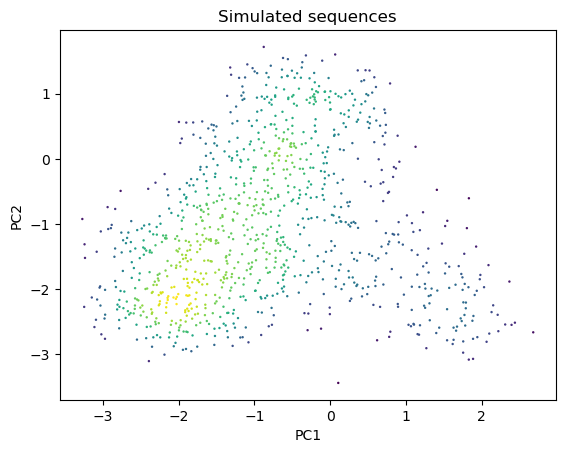

In [7]:
out_folder = "res_nucleotide_dyn/"
check_equilibration(out_folder, nat_msa, res.step_msa, res.steps);

## Function: `run_potts`


### Purpose
The `run_potts` function simulates a Potts model using the Metropolis algorithm only on aminoacids. It evolves a set of sequences (`start_msa`) over multiple steps to simulate an ensemble under the Potts Hamiltonian specified by `h` and `J`. Users can track simulation progress at specific intervals or obtain only the final configuration.

### Parameters
- `start_msa::Array`: Starting multiple sequence alignment (MSA), formatted as an `(L, N_chains)` array where `L` is the sequence length, and `N_chains` is the number of sequences.
- `h::Array{T,2}`: Array of size `(q, L)` representing the fields in the Potts model. `q` is the number of possible states (e.g., amino acids), and `L` is the sequence length.
- `J::Array{T,4}`: Array of size `(q, L, q, L)` representing the pairwise interactions between states at different sequence positions.

### Keyword Parameters
- `N_steps::Int`: Total number of simulation steps (default: `100`).
- `temp`: Temperature of the system, which influences acceptance in the Metropolis algorithm (default: `1.0`).
- `N_points::Union{Int, Nothing}`: Number of snapshots to store logarithmically across steps; mutually exclusive with `each_step` (default: `nothing`).
- `each_step::Union{Int, Nothing}`: Step interval for storing snapshots of MSA; mutually exclusive with `N_points` (default: `nothing`).
- `rand_init`: Boolean to initialize MSA randomly instead of using `start_msa` (default: `false`).
- `q::Int`: Number of possible states in the sequences (default: `21`).
- `verbose`: Boolean to print step information if `true` (default: `false`).

### Process
1. **Input Validation**:
   - Confirms that `J` has dimensions `(q, L, q, L)`.
   - Checks if `N_points` and `each_step` are both specified (not allowed).
   - Ensures that `N_points` (if specified) does not exceed `N_steps`.

2. **Initialization**:
   - Initializes random number generators for each chain.
   - If `rand_init` is `true`, each sequence in the chain is randomly initialized; otherwise, `start_msa` is used.

3. **Simulation**:
   - For each step, performs a Metropolis update (`run_simple_metropolis!`).
   - Saves snapshots of the MSA based on `N_points` or `each_step`, storing them in `step_msa`.

4. **Output Generation**:
   - Returns the final MSA or a sequence of MSAs at specified intervals.

### Returns
If `N_points` or `each_step` is specified:
- `NamedTuple{(:step_msa, :steps, :temp)}`:
  - `step_msa`: Array of MSAs saved at specified steps.
  - `steps`: Array of step indices for saved MSAs.
  - `temp`: Final temperature used in the simulation.

If neither `N_points` nor `each_step` is specified:
- `NamedTuple{(:msa, :temp)}`:
  - `msa`: Final MSA configuration.
  - `temp`: Final temperature used.

### Example Usage
```julia
start_msa = Int8[...]
h = Array{Float64}(undef, 21, L)
J = Array{Float64}(undef, 21, L, 21, L)

result = run_potts(start_msa, h, J, N_steps=1000, temp=0.5, N_points=10, verbose=true)


In [8]:
@time res_metrop = run_potts(start_msa, 
    h_dbd, 
    J_dbd,
    temp = 1., 
    N_steps = 1*10^5,  
    N_points = 20, 
    verbose = true);

1
3
6
11
20
37
69
127
233
428
784
1438
2636
4832
8858
16237
29763
54555
100000
 40.927760 seconds (6.23 M allocations: 247.611 MiB, 0.24% gc time, 1.02% compilation time)


θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000 N = 76 Meff = 1000
θ = 0.0 threshold = 0.0
M = 1000

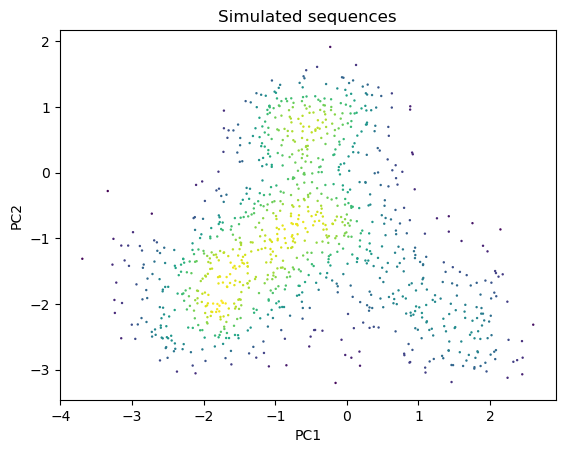

In [9]:
out_folder_metrop = "res_aminoacid_dyn/"
check_equilibration(out_folder_metrop, nat_msa, res_metrop.step_msa, res_metrop.steps)